In [9]:
#!pip install tensorflow

In [1]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
pd.options.mode.chained_assignment = None



2023-10-22 07:37:22.607104: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-22 07:37:22.640490: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-22 07:37:22.640516: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-22 07:37:22.640535: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-22 07:37:22.646423: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-22 07:37:22.646815: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

# Modelo de deep learning baseado no histórico recente (LSTM)

In [2]:
acao = "MGLU3.SA"

inicio = "2014-12-31"
final = "2023-10-20"

dados_acao = yf.download(acao, inicio, final)

dados_acao

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,0.243750,0.243750,0.231562,0.232812,0.215259,6323200
2015-01-05,0.235625,0.240625,0.229687,0.237187,0.219304,10326400
2015-01-06,0.238437,0.238437,0.233125,0.234062,0.216414,12572800
2015-01-07,0.237500,0.242187,0.234687,0.241875,0.223638,6454400
2015-01-08,0.239375,0.242187,0.237500,0.240000,0.221905,8393600
...,...,...,...,...,...,...
2023-10-13,1.870000,1.890000,1.800000,1.820000,1.820000,67624500
2023-10-16,1.850000,1.860000,1.780000,1.790000,1.790000,69482900
2023-10-17,1.750000,1.770000,1.680000,1.690000,1.690000,83406800


In [3]:
#nao pode ser ajustados

cotacao = dados_acao['Close'].to_numpy().reshape(-1, 1)

cotacao

array([[0.232812  ],
       [0.237187  ],
       [0.234062  ],
       ...,
       [1.69000006],
       [1.73000002],
       [1.61000001]])

In [4]:
tamanho_dados_treinamento = int(len(cotacao) * 0.8)

tamanho_dados_treinamento

1751

In [6]:
#escalar os dados entre 0 e 1, para deixar mais fácil o processamento
#dados em escala pré definidas são mais fáceis de lidar. 

escalador = MinMaxScaler(feature_range=(0, 1))

dados_entre_0_e_1_treinamento = escalador.fit_transform(cotacao[0: tamanho_dados_treinamento, :])

dados_entre_0_e_1_teste = escalador.transform(cotacao[tamanho_dados_treinamento: , :])

dados_entre_0_e_1 = list(dados_entre_0_e_1_treinamento.reshape(
    len(dados_entre_0_e_1_treinamento))) + list(dados_entre_0_e_1_teste.reshape(len(dados_entre_0_e_1_teste)))
                                                

dados_entre_0_e_1 = np.array(dados_entre_0_e_1).reshape(len(dados_entre_0_e_1), 1)

dados_entre_0_e_1

array([[0.00737532],
       [0.00753488],
       [0.00742091],
       ...,
       [0.06051971],
       [0.06197853],
       [0.05760207]])

In [7]:
dados_para_treinamento = dados_entre_0_e_1[0: tamanho_dados_treinamento, :]

#dados que serão usados para gerar o resultado
treinamento_x = []
#cotação que aconteceu de fato
treinamento_y = []


for i in range(60, len(dados_para_treinamento)):

    #60 ultimos dias
    treinamento_x.append(dados_para_treinamento[i - 60: i, 0])
    #cotacao
    treinamento_y.append(dados_para_treinamento[i, 0])

    if i <= 61:

        print(treinamento_x)
        print(treinamento_y)



[array([0.00737532, 0.00753488, 0.00742091, 0.00770585, 0.00763747,
       0.00734115, 0.00743232, 0.00734115, 0.00720438, 0.00718159,
       0.00724997, 0.00720438, 0.00686247, 0.00691944, 0.00688527,
       0.00691944, 0.00686247, 0.00663453, 0.00641797, 0.0066915 ,
       0.00663453, 0.00668012, 0.006361  , 0.00628121, 0.00617865,
       0.00582532, 0.00575694, 0.00588233, 0.00549483, 0.0056088 ,
       0.00582532, 0.00585953, 0.00613306, 0.00612165, 0.00620145,
       0.00640659, 0.00622424, 0.0063838 , 0.00577974, 0.00581395,
       0.00558601, 0.00520988, 0.0051415 , 0.00495915, 0.00466283,
       0.00491356, 0.00486797, 0.00515292, 0.00487939, 0.00469704,
       0.00462865, 0.00457165, 0.00468562, 0.00470842, 0.00470842,
       0.00466283, 0.00458307, 0.00456027, 0.00452606, 0.00462865])]
[0.004685621274704243]
[array([0.00737532, 0.00753488, 0.00742091, 0.00770585, 0.00763747,
       0.00734115, 0.00743232, 0.00734115, 0.00720438, 0.00718159,
       0.00724997, 0.00720438, 0.00

In [8]:
#transformando as listas em arrays e dando reshape 3d 

treinamento_x, treinamento_y = np.array(treinamento_x), np.array(treinamento_y)

treinamento_x

treinamento_x = treinamento_x.reshape(treinamento_x.shape[0], treinamento_x.shape[1], 1)

treinamento_x

array([[[0.00737532],
        [0.00753488],
        [0.00742091],
        ...,
        [0.00456027],
        [0.00452606],
        [0.00462865]],

       [[0.00753488],
        [0.00742091],
        [0.00770585],
        ...,
        [0.00452606],
        [0.00462865],
        [0.00468562]],

       [[0.00742091],
        [0.00770585],
        [0.00763747],
        ...,
        [0.00462865],
        [0.00468562],
        [0.00485659]],

       ...,

       [[0.4996246 ],
        [0.4828482 ],
        [0.45148354],
        ...,
        [0.22901345],
        [0.22098994],
        [0.22974286]],

       [[0.4828482 ],
        [0.45148354],
        [0.45184825],
        ...,
        [0.22098994],
        [0.22974286],
        [0.22208405]],

       [[0.45148354],
        [0.45184825],
        [0.44893061],
        ...,
        [0.22974286],
        [0.22208405],
        [0.21369583]]])

In [24]:
#construindo o modelo

modelo = Sequential()

#vamos criar um modelo com 50 neurônios
#return sequences = True pois vamos usar outro LSTM depois.
#definir o shape, que no caso são 60 informações para gerar uma.
#Adicionar mais neurônios com o dense, 25 e 1
#Não se apegue a isso agora, é apenas um arquitetura de deep learning.

modelo.add(LSTM(50, return_sequences=True, input_shape = (treinamento_x.shape[1], 1)))
modelo.add(LSTM(50, return_sequences=False))
modelo.add(Dense(25))
modelo.add(Dense(1))

treinamento_x.shape[1]

60

In [25]:
#copilando o modelo

# a função de loss é a forma de medir o erro do modelo, que nesse caso
#é o classico erro médio quadrático da que é usado em regressão linear
#otimizador e medida de erro

modelo.compile(optimizer="adam", loss="mean_squared_error") 

In [27]:
#agora com o modelo copilado e os dados, podemos treinar o modelo

modelo.fit(treinamento_x, treinamento_y, batch_size=1, epochs=5)

Epoch 1/5
1691/1691 [==============================] - 25s 15ms/step - loss: 7.6985e-04
Epoch 2/5
1691/1691 [==============================] - 25s 15ms/step - loss: 5.8204e-04
Epoch 3/5
1691/1691 [==============================] - 25s 15ms/step - loss: 7.1219e-04
Epoch 4/5
1691/1691 [==============================] - 25s 15ms/step - loss: 3.7571e-04
Epoch 5/5
1691/1691 [==============================] - 23s 14ms/step - loss: 4.7917e-04


In [28]:
#criar dados de teste

dados_teste = dados_entre_0_e_1[tamanho_dados_treinamento - 60:, :]

teste_x = []
teste_y = cotacao[tamanho_dados_treinamento: , :] 

for i in range(60, len(dados_teste)):
    teste_x.append(dados_teste[i - 60: i, 0])
    

In [29]:
#reshape
teste_x = np.array(teste_x)
teste_x = teste_x.reshape(teste_x.shape[0], teste_x.shape[1], 1)

In [30]:
#pegando predições do modelo

predicoes = modelo.predict(teste_x)

#tirando a escala dos dados

predicoes = escalador.inverse_transform(predicoes)

predicoes

14/14 [==============================] - 1s 9ms/step


array([[6.242831 ],
       [6.573959 ],
       [6.8339715],
       [6.5239553],
       [6.6429696],
       [6.728236 ],
       [7.0860677],
       [6.8266153],
       [6.9320498],
       [6.993451 ],
       [6.6553493],
       [6.5681143],
       [6.430345 ],
       [6.3839464],
       [6.5412626],
       [6.6319323],
       [6.8826385],
       [6.528541 ],
       [6.4915786],
       [6.762419 ],
       [6.8362074],
       [6.70354  ],
       [6.4673457],
       [6.1696424],
       [6.133778 ],
       [6.036293 ],
       [6.152982 ],
       [6.115168 ],
       [6.296618 ],
       [6.3493977],
       [6.3325634],
       [6.0135713],
       [6.0544667],
       [6.2205057],
       [6.082498 ],
       [5.837204 ],
       [5.520235 ],
       [5.122805 ],
       [5.1926603],
       [5.5271473],
       [5.8177967],
       [5.803273 ],
       [5.8266106],
       [5.962623 ],
       [6.4252944],
       [6.519319 ],
       [6.465798 ],
       [6.821741 ],
       [6.849081 ],
       [6.803755 ],


In [31]:
#pegando o erro médio quadrático (RMSE)

rmse = np.sqrt(np.mean(predicoes - teste_y) ** 2)
rmse

0.08564461502310348

In [32]:
#criando o grafico do modelo


treinamento = dados_acao.iloc[:tamanho_dados_treinamento, :]
df_teste = pd.DataFrame({"Close": dados_acao['Close'].iloc[tamanho_dados_treinamento:],
                        "predicoes": predicoes.reshape(len(predicoes))})


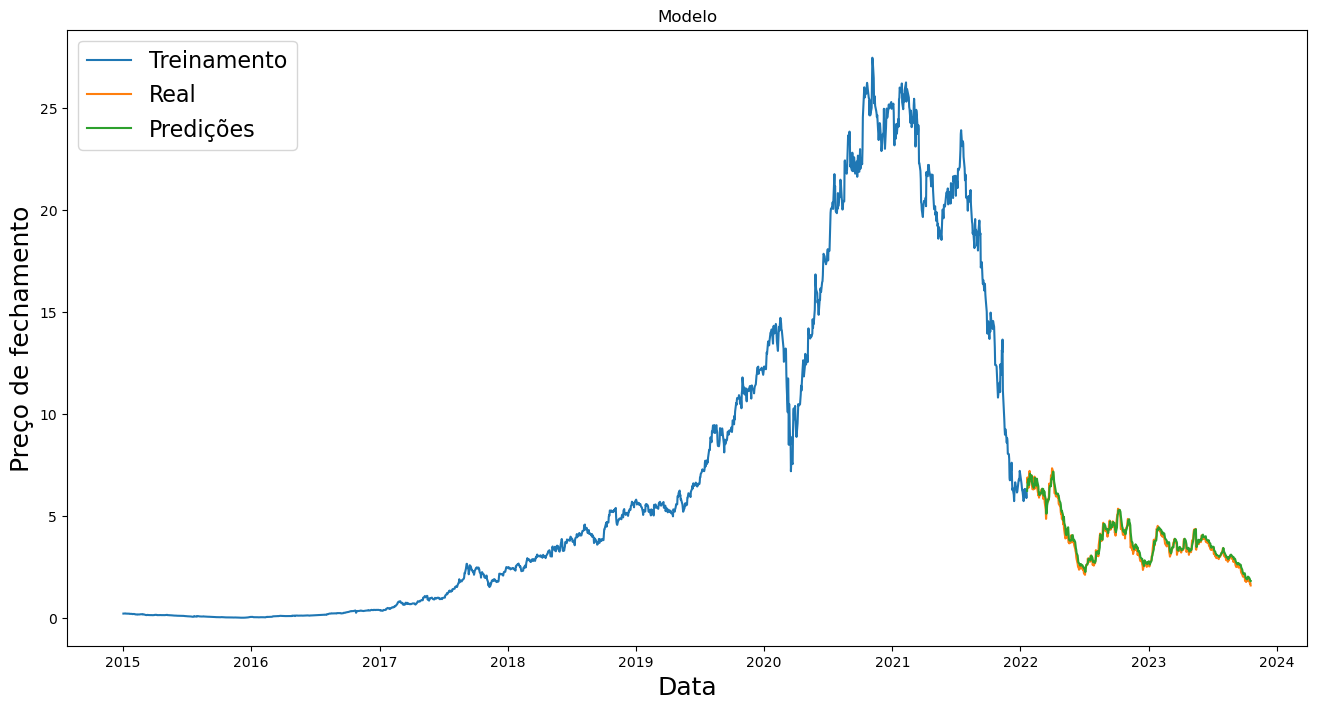

In [33]:
plt.figure(figsize =(16, 8))
plt.title('Modelo')
plt.xlabel('Data', fontsize = 18)
plt.ylabel("Preço de fechamento", fontsize = 18)
plt.plot(treinamento['Close'])
plt.plot(df_teste[['Close', 'predicoes']])
plt.legend(['Treinamento', 'Real', 'Predições'], loc=2, prop={'size': 16})
plt.show()

In [34]:
df_teste.sort_index()

df_teste

,Close,predicoes
Date,,
2022-01-20,6.65,6.242831
2022-01-21,6.90,6.573959
2022-01-24,6.39,6.833972
2022-01-25,6.72,6.523955
2022-01-26,6.75,6.642970
...,...,...
2023-10-13,1.82,2.025832
2023-10-16,1.79,1.949270
2023-10-17,1.69,1.899568


In [35]:
#o preço é legal, mas o importante é acertar pra qual mercado o lado vai. Sera q isso foi feito?

#calcular media de acertos e expectativa de lucro

df_teste['variacao_percentual_acao'] = df_teste['Close'].pct_change()
df_teste['variacao_percentual_modelo'] = df_teste['predicoes'].pct_change()

df_teste = df_teste.dropna()

df_teste['var_acao_maior_menor_que_zero'] = np.where(df_teste['variacao_percentual_acao'] > 0, 
                                                      True, False)
df_teste['var_modelo_maior_menor_que_zero'] = np.where(df_teste['variacao_percentual_modelo'] > 0, 
                                                      True, False)

df_teste['acertou_o_lado'] = np.where(df_teste['var_acao_maior_menor_que_zero'] == df_teste['var_modelo_maior_menor_que_zero']
                                      , True, False)

df_teste['variacao_percentual_acao_abs'] = df_teste['variacao_percentual_acao'].abs()

df_teste

,Close,predicoes,variacao_percentual_acao,variacao_percentual_modelo,var_acao_maior_menor_que_zero,var_modelo_maior_menor_que_zero,acertou_o_lado,variacao_percentual_acao_abs
Date,,,,,,,,
2022-01-21,6.90,6.573959,0.037594,0.053041,True,True,True,0.037594
2022-01-24,6.39,6.833972,-0.073913,0.039552,False,True,False,0.073913
2022-01-25,6.72,6.523955,0.051643,-0.045364,True,False,False,0.051643
2022-01-26,6.75,6.642970,0.004464,0.018243,True,True,True,0.004464
2022-01-27,7.22,6.728236,0.069630,0.012836,True,True,True,0.069630
...,...,...,...,...,...,...,...,...
2023-10-13,1.82,2.025832,-0.047120,-0.008464,False,False,True,0.047120
2023-10-16,1.79,1.949270,-0.016484,-0.037793,False,False,True,0.016484
2023-10-17,1.69,1.899568,-0.055866,-0.025497,False,False,True,0.055866


In [38]:
acertou_lado = df_teste['acertou_o_lado'].sum()/len(df_teste['acertou_o_lado'])
errou_lado = 1 - acertou_lado

media_lucro = df_teste.groupby('acertou_o_lado')['variacao_percentual_acao_abs'].mean()

exp_mat_lucro = acertou_lado * media_lucro[1] - media_lucro[0] * errou_lado

ganho_sobre_perda = media_lucro[1]/media_lucro[0]

print(media_lucro)
print(ganho_sobre_perda)
print(acertou_lado)
print(exp_mat_lucro * 100)

acertou_o_lado
False    0.034721
True     0.038822
Name: variacao_percentual_acao_abs, dtype: float64
1.118107600038703
0.4988558352402746
0.19662842470342773


In [40]:
#criando um código que você passa 60 dias e ele devolve a cotação
#resumindo: vamos descobrir o preço da petrobras de hoje/amanha com esse modelo

data_hoje = datetime.now()

#se quiser escolher um dia, basta fazer assim

# data_hoje = datetime.now() - timedelta(days = 1)

if data_hoje.hour > 18:
    
    final = data_hoje
    inicial = datetime.now() - timedelta(days = 252)
    
else:
    final = data_hoje - timedelta(days = 1)
    inicial = datetime.now() - timedelta(days = 252)
    
#nao vai botar outra ação aqui hein kkkkkkkk
cotacoes = yf.download(acao, inicio, final) 
ultimos_60_dias = cotacoes['Close'].iloc[-60:].values.reshape(-1, 1)

ultimos_60_dias_escalado = escalador.transform(ultimos_60_dias)

teste_x = []
teste_x.append(ultimos_60_dias_escalado)
teste_x = np.array(teste_x)
teste_x = teste_x.reshape(teste_x.shape[0], teste_x.shape[1], 1)

previsao_de_preco = modelo.predict(teste_x)
previsao_de_preco = escalador.inverse_transform(previsao_de_preco)

print(previsao_de_preco)

[*********************100%%**********************]  1 of 1 completed
1/1 [==============================] - 0s 16ms/step
[[1.6813526]]


# Sugestões:
<br>

- Melhorar as estatísticas de avaliação (dias seguidos ganhando, max DD, etc)
<br>

- Rodar pra todas as ações do ibovespa e criar uma expectativa matemática da expectativa matemática. Isso vai deixar o resultado final ainda mais robusto, definando a aloção do $ basedo na liquidez


In [41]:
dados_acao

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,0.243750,0.243750,0.231562,0.232812,0.215259,6323200
2015-01-05,0.235625,0.240625,0.229687,0.237187,0.219304,10326400
2015-01-06,0.238437,0.238437,0.233125,0.234062,0.216414,12572800
2015-01-07,0.237500,0.242187,0.234687,0.241875,0.223638,6454400
2015-01-08,0.239375,0.242187,0.237500,0.240000,0.221905,8393600
...,...,...,...,...,...,...
2023-10-13,1.870000,1.890000,1.800000,1.820000,1.820000,67624500
2023-10-16,1.850000,1.860000,1.780000,1.790000,1.790000,69482900
2023-10-17,1.750000,1.770000,1.680000,1.690000,1.690000,83406800
